In [130]:
import numpy as np
import numpy.linalg as npl
import math
import matplotlib.pyplot as plt
import sys
from scipy.integrate import odeint

# 9.3 Epidemic Dynamics

**Simple SIR Model - Activity ONE**

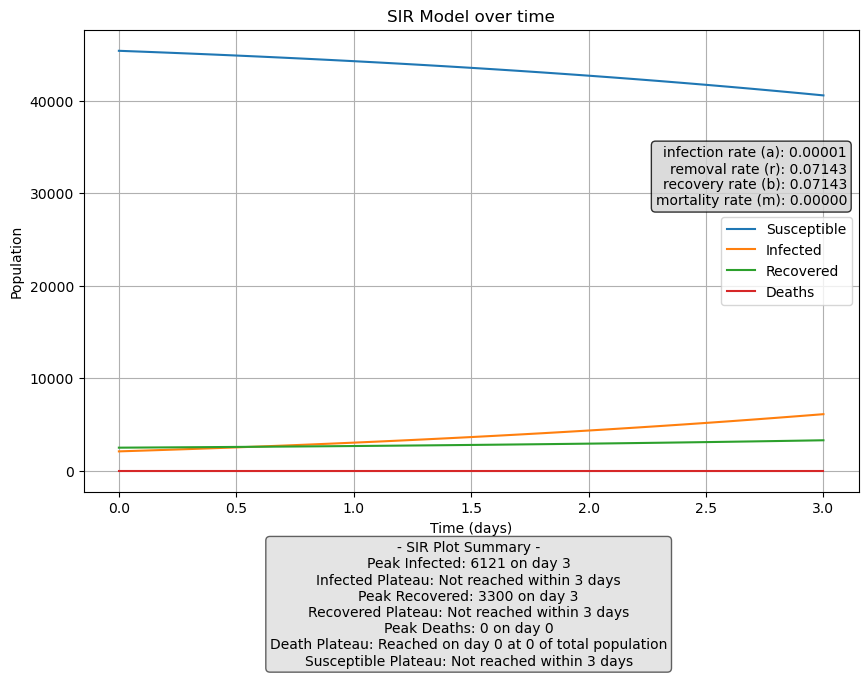

In [131]:

#Use Pseudocode from Calculus in Context, Chapter 2 page 69 to plot the 3 functions S, I and R. Use a (.00001)and b (14) as varibles instead of numbers
#Use a fixed plot window with y as the total height and fix the number of days you want to explore.
#Once it is working, add a new rate equation for Deaths by splitting up the "Recovered" 2 equations - for example 10 percent pass to death and 90 percent pass to recovered.
#Please comment your code.

# threshold controls sensitivity: lower = flatter
# min_length_fraction ensures validity
def findPlateau(t_values, y_values, threshold=1.0, min_length_fraction=0.1):
    # ensures min_length scales with larger data sets, but doesn't get too small for small data sets
    min_length = max(5, int(len(t_values) * min_length_fraction))
    count = 0
    start_idx = None
    # calculate y_values deltas
    deltas = [abs(y2 - y1) for y1, y2 in zip(y_values[:-1], y_values[1:])]

    # determine count of deltas that are within plateau
    for idx, delta in enumerate(deltas):
        if delta < threshold:
            count += 1
            if count == min_length:
                # if deltas within threshold meet min_length determine start index of plateau
                start_idx = idx - min_length + 1
                break
        else:
            count = 0

    if start_idx is not None:
        return (f"Reached on day {t_values[start_idx]:.0f} at {y_values[start_idx]:.0f} of total population")
    else:
        return (f"Not reached within {max(t_values):.0f} days")

def plotSIR(a, B, b, m, t_values, S_values, I_values, R_values, D_values, total_pop, t_initial, t_final):
    plt.figure(figsize=(10, 6))
    lines = [
        (S_values, "Susceptible"),
        (I_values, "Infected"),
        (R_values, "Recovered"),
        (D_values, "Deaths")
    ]
    for y_values, label in lines:
        #plt.plot(t_values, y_values, label, marker='.', markersize=4) # if you want to see steps on line
        plt.plot(t_values, y_values, label = label)
    plt.xlabel("Time (days)")
    plt.ylabel("Population")
    plt.title("SIR Model over time")
    plt.xlim(t_initial, t_final)
    plt.ylim(0, total_pop)
    plt.legend()
    plt.grid(True)
    plt.autoscale()
    param_text = (
        f"infection rate (a): {a:.5f}\n"
        f"removal rate (r): {1/B:.5f}\n"
        f"recovery rate (b): {b:.5f}\n"
        f"mortality rate (m): {m:.5f}"
    )
    plt.annotate(
        param_text,
        xy=(0.985, 0.75),             # position in axes fraction coords
        xycoords='axes fraction',
        fontsize=10,
        ha='right',
        va='top',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8)
    )
    peak_text = (
        f"- SIR Plot Summary -\n"
        f"Peak Infected: {max(I_values):.0f} on day {t_values[I_values.index(max(I_values))]:.0f}\n"
        f"Infected Plateau: {findPlateau(t_values, I_values)}\n"
        f"Peak Recovered: {max(R_values):.0f} on day {t_values[R_values.index(max(R_values))]:.0f}\n"
        f"Recovered Plateau: {findPlateau(t_values, R_values)}\n"
        f"Peak Deaths: {max(D_values):.0f} on day {t_values[D_values.index(max(D_values))]:.0f}\n"
        f"Death Plateau: {findPlateau(t_values, D_values, .5)}\n"
        f"Susceptible Plateau: {findPlateau(t_values, S_values)}"
    )
    
    plt.figtext(
        0.51, -0.175, peak_text,
        wrap=True, ha='center', fontsize=10,
        bbox=dict(boxstyle="round", facecolor="lightgray", edgecolor="black", alpha=0.6)
    )
    plt.show()



def SIR(t_initial,          # start day of model
        t_final,            # end day of model
        step_scale,         # 0 to X number to deterimine how many data points are taken between t_initial and t_final. 1 means same number of steps as days, so 1 to 1
        a,                  # scaling factor, rate of people getting sick per contact
        B,                  # coefficient for removal of Infected / X days
        total_pop,          # total Population
        mortality_risk,     # percentage (in decimal form) of those that are infected that die
        I_init,             # infected on start day
        R_init,             # recovered on start day
        D_init,             # deaths on start day                  
        output_path):       # path for data to write to

    t = t_initial                               # start time
    S = total_pop - I_init - R_init - D_init    # total susceptible
    I = I_init                                  # total infected
    R = R_init                                  # total recovered
    D = D_init                                  # total dead
    
    #mortality_risk = .1  # percentage (in decimal form) of those that are infected that die
    #a = .00001  # scaling factor, rate of people getting sick per contact
    r = 1/B    # removal (recovery + deaths) rate
    b = r * (1 - mortality_risk) # recovery rate
    m = r * mortality_risk # mortality rate
    
    steps = (t_final - t_initial) * step_scale # how many data points within set days
    deltat = (t_final - t_initial)/steps

    sys.stdout = open(output_path, "w") # write output to file instead of console
    print("{:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15} {:<15}".
        format("Increment #", "Susceptible", "Infected", "Recovered", "Deaths", "Sprime", "Iprime", "Rprime"))        
    print("{:<15} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f}".
        format(t, S, I, R, D))

    # store values for graph, initialize lists with starting values
    t_values = [t]
    S_values = [S]
    I_values = [I]
    R_values = [R]
    D_values = [D]
    for  k in range(steps):
        Sprime = -a * S * I
        Iprime = (a * S * I) - (I * r)
        Rprime = I * b
        Dprime = I * m
        deltaS = Sprime * deltat
        deltaI = Iprime * deltat
        deltaR = Rprime * deltat
        deltaD = Dprime * deltat
        # update values with delta change
        t = t + deltat
        S = S + deltaS
        I = I + deltaI
        R = R + deltaR
        D = D + deltaD
        # save values in lists
        t_values.append(t)
        S_values.append(S)
        I_values.append(I)
        R_values.append(R)
        D_values.append(D)
        print("{:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f}, {:<15.3f}".
            format(t, S, I, R, D, Sprime, Iprime, Rprime, Dprime))
    print("Final:")
    print("{:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f} {:<15.3f}, {:<15.3f}".
            format(t, S, I, R, D, Sprime, Iprime, Rprime, Dprime))
    # stop writing to file and switch back to console output
    sys.stdout.close()
    sys.stdout = sys.__stdout__
    # plot SIR Graph
    plotSIR(a, B, b, m, t_values, S_values, I_values, R_values, D_values, total_pop, t_initial, t_final)
    


t_initial = 0                           # start day of model
t_final = 3                             # end day of model

# 10 represents 30 from pseudocode
step_scale = 10                         # 0 to X number to deterimine how many data points are taken between t_initial and t_final. 1 means same number of steps as days, so 1 to 1

a = 0.00001                             # scaling factor, rate of people getting sick per contact
B = 14                                  # coefficient for removal of Infected / X days
total_pop = 50000                       # total Population
mortality_risk = 0                      # percentage (in decimal form) of those that are infected that die
I_init = 2100                           # infected on start day
R_init = 2500                           # recovered on start day
D_init = 0                              # deaths on start day                  
output_path = "sir_output.txt"          # path for data to write to
SIR(t_initial, t_final, step_scale, a, B, total_pop, mortality_risk, I_init, R_init, D_init, output_path)



#Shortest Mathplotlib tutorial ever.
#Just use this - you need to arrange the data each time as below - but really you don't need all the bells and whistles.

#import matplotlib.pyplot as plt
#plt.plot([1, 2, 3, 4], [1, 9, 3, 1])

#plt.plot([1, 2, 3, 4], [16, 7, 5, 2])

#plt.plot([1,2, 3, 4], [1, 2, 4, 4])



**Question 1:**
Test your model with a = .00001 and b = 10 over 50 days and check with the given textbook. Show the output. Provide simple context for this model with comments or text.


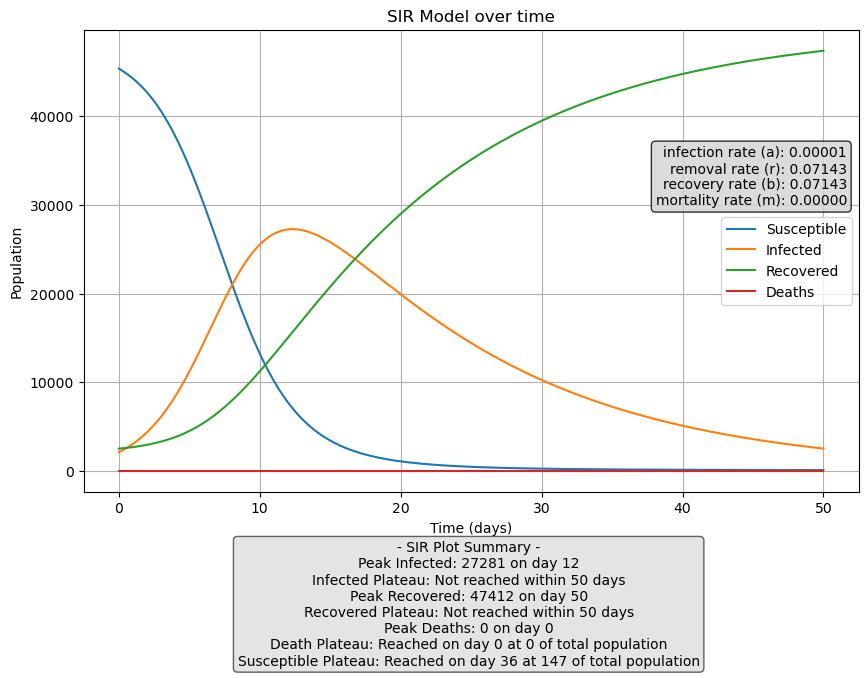

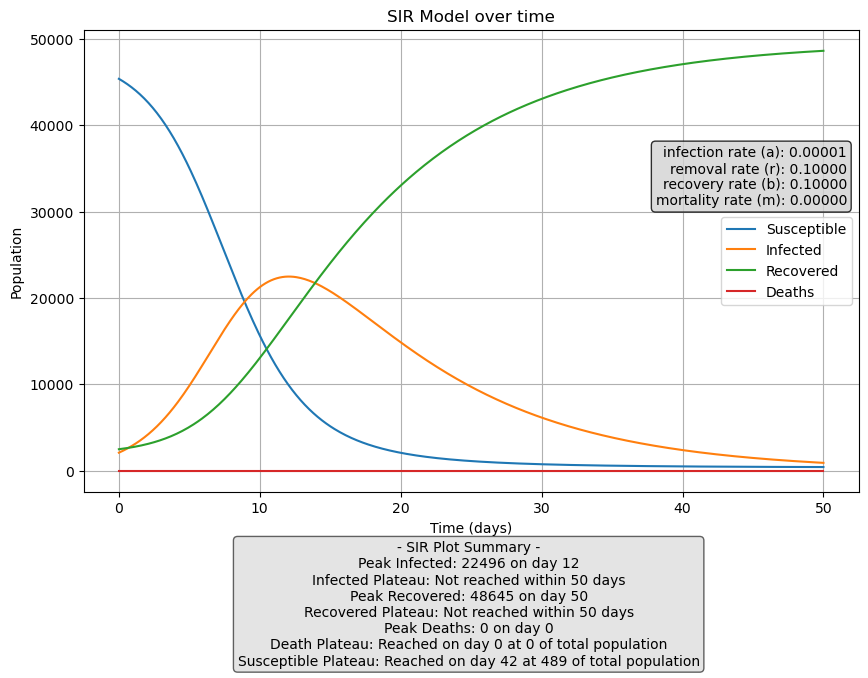

In [132]:
t_initial = 0                           # start day of model
t_final = 50                           # end day of model

# 10 represents the equivalent ratio of steps given in textbook
step_scale = 10                         # 1 to X number to deterimine how many data points are taken between t_initial and t_final. 1 means same number of steps as days, so 1 to 1

a = 0.00001                             # scaling factor, rate of people getting sick per contact
B = 14                                  # coefficient for removal of Infected / B days
total_pop = 50000                       # total Population
mortality_risk = 0                      # percentage (in decimal form) of those that are infected that die
I_init = 2100                           # infected on start day
R_init = 2500                           # recovered on start day
D_init = 0                              # deaths on start day                  
output_path = "sir_output-1a.txt"       # path for data to write to
SIR(t_initial, t_final, step_scale, a, B, total_pop, mortality_risk, I_init, R_init, D_init, output_path)


t_initial = 0                           # start day of model
t_final = 50                           # end day of model

# 10 represents the equivalent ratio of steps given in textbook
step_scale = 10                         # 1 to X number to deterimine how many data points are taken between t_initial and t_final. 1 means same number of steps as days, so 1 to 1

a = 0.00001                             # scaling factor, rate of people getting sick per contact
B = 10                                  # coefficient for removal of Infected / B days
total_pop = 50000                       # total Population
mortality_risk = 0                      # percentage (in decimal form) of those that are infected that die
I_init = 2100                           # infected on start day
R_init = 2500                           # recovered on start day
D_init = 0                              # deaths on start day                  
output_path = "sir_output-1b.txt"       # path for data to write to
SIR(t_initial, t_final, step_scale, a, B, total_pop, mortality_risk, I_init, R_init, D_init, output_path)


**Question 2:** Using your SIRPLOT code above, explore what happens when you change the length of time a disease takes to recover (which may happen with a new medicine for example). Provide examples from your model in code blocks and context and explanation in textblocks.



**Question 3:** Using your SIRPLOT code above, explore what happens to the course of a disease when you change the transmission coeffient a (which happens if people self-isolate for example). Provide examples from your model in code blocks and context and explanation in textblocks.

**SIR with Differential Equations**

**Question 4:**
Look at the following implementation of SIR (adapted from the https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/) using differential equations. 

How is it the same and how is it different to SIRPLOT? Answer here with code and text examples.

**Question 5:**
Can you use this model to explore the Questions 2 and 3 above. Answer here.

/tmp/ipykernel_506/3022371191.py:65: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')


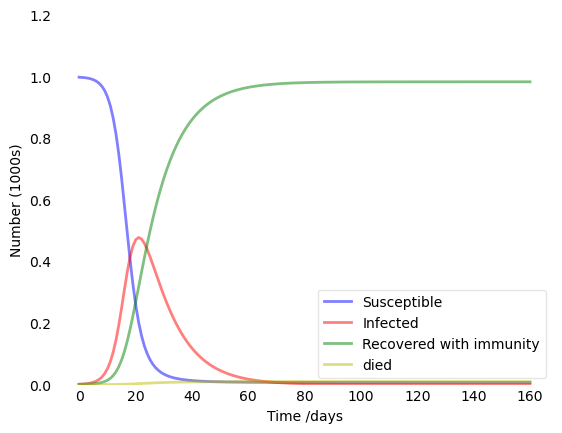

In [133]:


#Using Differential Equations


# Total population, N.
N = 1000

timeperiod =160
# Initial number of infected and recovered individuals, I0 and R0.
I0=1
R0 =1
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

D0 =0


#TRY modifying a and b

# Contact rate, a, and mean recovery rate, b, (in 1/days).

days=10 #(days to recover - how long are the infected able to pass it on )

a=.0005 #(more contact, how quickly it spreads)

b=1/days 

deathrate = .01
recover = 1 - deathrate





# A grid of time points (in days)
t = np.linspace(0, 160, timeperiod)

# The SIR model differential equations.
def deriv(y, t, N, a, b):
    S, I, R, D = y
    dSdt = -a * S * I 
    dIdt = a * S * I  - b * I
    dRdt = recover * (b * I)
    dDrt = deathrate * (b * I) 
    return dSdt, dIdt, dRdt, dDrt

# Initial conditions vector
y0 = S0, I0, R0, D0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, a, b))
S, I, R, D = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
#ax = fig.add_subplot(111, axis_bgcolor='#dddddd', axisbelow=True)
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, D/1000, 'y', alpha=0.5, lw=2, label='died')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

**SIR with Matrices**

**Question 6:**
How is this implementation the same and different than SIRPLOT and the differential equation SIRmodel? Can you explore changes in the transmission coefficent and recovery rate the same way? Answer here.

**Question 7:**
What are the advantages and disadvantages of this matrix model?  Answer here.

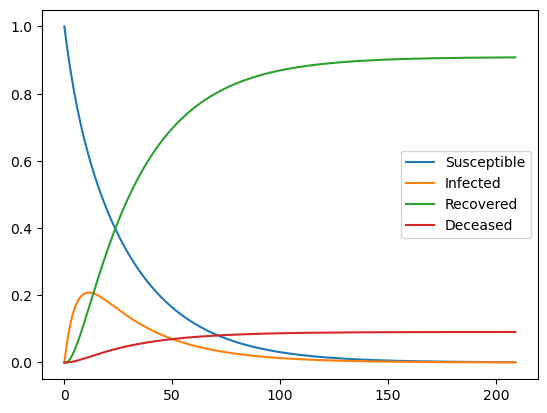

In [134]:


T  = 210 #number of days
a= .05         # % new infection each day
aS= 1 - a      # % remain suseptible
rnI= .04       # recover no immunity
rI= .1         # recover with immunity
rD= .01        # die from disease


A = np.matrix([[aS,rnI,0,0],[rnI+rD,(1-(rnI +rI + rD)) ,0,0],[0,rI,1,0],[0,rD,0,1]]) #dynamics matrix
x1 = np.array([1,0,0,0]) #initial state: everyone healthy
stateTraj = np.hstack([np.vstack(x1),np.zeros((4,T-1))]) #initialize trajectory with 0s
for t in range(T-1):
    stateTraj[:,t+1] = np.matmul(A,stateTraj[:,t])

for i in range(len(stateTraj)):
    plt.plot(range(T),stateTraj[i])

plt.legend(["Susceptible","Infected","Recovered","Deceased"])

**Question 8:**
Read Calculus in Context, Chapter 4. This explores additional models that can be explored using this method. 
Copy and paste SIR plot here and  modify to model the Lotka-Voerra Model from page 193 number 7. Explore some of the questions a - f on your own and add some short notes about this model. note: The scaling factor for lynx is 60 (page 194, part c)."plot H and 60L"




**Question 9:**
Chapter 4 explores additional models that can be explored using this method. 
Copy and paste SIR plot here and  modify to model the Fermentation Model from page 195 numbers 8/9/10/11.  HOWEVER, to implement the model you must work through all the steps. YOu may discuss in Piazza.





**Question 10:** 

Create your own species (or other) SIR type model. 

For example, can you add elements to SIR that model some percentage of infected dying? Or immunity that is not permentant?  Or create an ecosystem of your own (Aliens eat bears,bears eat mice, Mice drink wine?). You may discuss ideas on Piazza and I can help with your equations :)


Provide code, sample output, and description.

**Finally:**
    
What are some thoughts about modeling from this project? 
Which model was the simpliest?
Which expressed the underlying ideas best?
Which was good for a "snapshot" of the ideas?
As we use more packages for mathematical modelling do we sometimes loss track of the ideas?

**Want more?** Check out Chapter 8 in Calculus in Context. This project is the gateway to Dynamical Systems.